In [1]:
import findspark

findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession


spark = SparkSession.builder.getOrCreate()

In [3]:
df = spark.read.csv('data/banking.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)



In [4]:
import pandas as pd


# get data statistics
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934071,17,98
duration,41188,258.2850101971448,259.2792488364657,0,4918
campaign,41188,2.567592502670681,2.7700135429023445,1,56
pdays,41188,962.4754540157328,186.91090734474153,0,999
previous,41188,0.17296299893172767,0.49490107983929027,0,7
emp_var_rate,41188,0.0818855006312578,1.5709597405170233,-3.4,1.4
cons_price_idx,41188,93.57566436827008,0.5788400489541244,92.201,94.767
cons_conf_idx,41188,-40.50260027192037,4.628197856174547,-50.8,-26.9
euribor3m,41188,3.621290812858366,1.734447404851269,0.634,5.045


In [5]:
import seaborn as sns


#plot correlations in numeric features
sns.pairplot(df.select(numeric_features).toPandas())

In [6]:
df = df.drop('month')
df = df.drop('day_of_week')
df = df.withColumnRenamed('y', 'label')

In [7]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler


categoricalColumns = ['job',\
                      'marital',\
                      'education',\
                      'default',\
                      'housing',\
                      'loan',\
                      'contact',\
                      'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

# numericCols = ['age', 'duration', 'campaign', 'pdays', 'previous']
numericCols = ['age',\
               'duration',\
               'campaign',\
               'pdays',\
               'previous',\
               'emp_var_rate',\
               'cons_price_idx',\
               'cons_conf_idx',\
               'euribor3m',\
               'nr_employed',\
               'label']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [8]:
from pyspark.ml import Pipeline


cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- label: integer (nullable = true)



In [9]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 28839
Test Dataset Count: 12349


In [10]:
from pyspark.ml.classification import LogisticRegression


lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

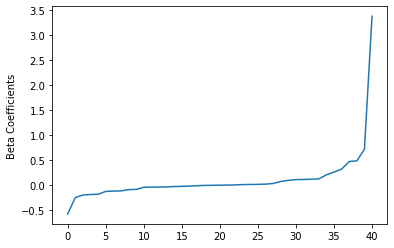

In [11]:
import matplotlib.pyplot as plt
import numpy as np


beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

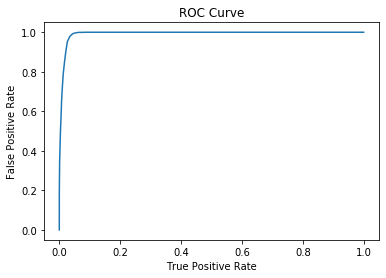

Training set areaUnderROC: 0.9923713428002683


In [14]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()